In [1]:
# Importing required modules
import warnings
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch
import cv2
import pandas as pd
import numpy as np
import pathlib
import os,sys
from scipy.special import softmax
from torchvision.models import resnet50
from astropy.io import fits
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, f1_score
warnings.filterwarnings('ignore')

/opt/conda/envs/akash/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def f1_score(preds, targets):
    preds = torch.round(torch.sigmoid(preds))
    tp = torch.sum(targets * preds)
    fp = torch.sum((1 - targets) * preds)
    fn = torch.sum(targets * (1 - preds))
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return f1


In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, X_train, y_train, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        label = self.y_train.iloc[index]
        image_path = self.X_train.iloc[index]['ID']
        hdulist = fits.open(f"lens_finding/SpaceBasedTraining/files/imageEUC_VIS-{'%05d'%image_path}.fits")
        data = hdulist[0].data
        data = (data - np.min(data)) / (np.max(data) - np.min(data))
        data = np.uint8(data * 255)
        data = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)
        image = self.transform(data)
        self.label = torch.tensor(label)
        return image, self.label

In [4]:
def run():
    torch.cuda.empty_cache()
    #  Loading the train data
    train_df = pd.read_csv(train_csv_path)
    # building training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop(columns=['is_lens']), train_df['is_lens'], test_size=0.1, random_state=SEED)

    y_valid = y_valid.astype(float)

    # building training and validation sets
    X_test = X_valid
    y_test = y_valid
    print('Data lengths: ', len(X_test), len(y_test))

    # Data transforms
    test_transforms = transforms.Compose([transforms.ToPILImage(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

    # DataLoader
    valid_dataset = CustomDataset(root_dir,X_test, y_test,test_transforms)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

    # Loading the pretrained model here
    if 'efficientnet' in model_name:
        model = EfficientNet.from_pretrained(model_name)
        model._fc = nn.Sequential(
            nn.Linear(mid_features, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
    else:
        model = resnet50(pretrained = True)
        model._fc = nn.Sequential(
            nn.Linear(mid_features, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    # loading the trained weights
    model.load_state_dict(torch.load(pretrained_model)['model_state_dict'])
    model.eval()
    # Training model
    model.to(device)
    
    total = 0
    correct = 0
    valid_acc = 0
    f1_scores = []
    label = np.array([])
    outputs = np.empty((0,1))
    
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(valid_loader, total=len(valid_loader))):
            images, targets = data
            images = images.to(device)
            targets = torch.tensor(targets, dtype=torch.float).unsqueeze(1)
            targets = targets.cpu()
            output = model(images)
            output = torch.sigmoid(output).cpu()
            pred = output>= 0.5
            # print(pred.shape, targets.shape)
            f1_scores.append(f1_score(pred.to(torch.int), targets))
            label = label.reshape(-1, 1)
            label = np.concatenate((label, np.array(targets.cpu())), axis=0)
            
            # label = np.concatenate((label, np.array(pred.cpu())), axis=0)
            outputs = np.concatenate((outputs, np.array(output.cpu())), axis=0)
            correct += (pred == targets).sum().item()
            total += pred.size(0)
    valid_acc = correct/total * 100
    val_f1 = np.mean(np.array([x.cpu().numpy() for x in f1_scores]))
    valid_acc = correct/total * 100
    print(f'Valid Accuracy: {valid_acc}')
    print(f'Valid F1 score: {val_f1}')
    return X_test, y_test, label, outputs

In [5]:
# This helps make all other paths relative
base_path = pathlib.Path().absolute()
# Model choice
# arg:  efficientnet-b0, efficientnet-b3, resnet50, b7")
model_name = 'efficientnet-b7'
pretrained_model = f'checkpoint_237.pth.tar'
# Input of the required hyperparameters
BATCH_SIZE = 128
# 1280, 1536, 2048, 2560
mid_features = 2560
SEED = 42
num_workers = 2
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
base_path = 'lens_finding/SpaceBasedTraining'
root_dir = base_path + '/files'
if not os.path.exists(f'{root_dir}'):
    print("Dataset missing.")
    sys.exit()
train_csv_path = f'{base_path}/classifications.csv'

X_test, y_test, label, outputs = run()

Data lengths:  1800 1800
Loaded pretrained weights for efficientnet-b7


100%|██████████| 15/15 [00:03<00:00,  3.79it/s]

Valid Accuracy: 91.05555555555556
Valid F1 score: 0.9318779706954956


In [6]:
auc_score = roc_auc_score(label, outputs>= 0.5)
print("Auc Score: ", auc_score)

Auc Score:  0.9239376672798734


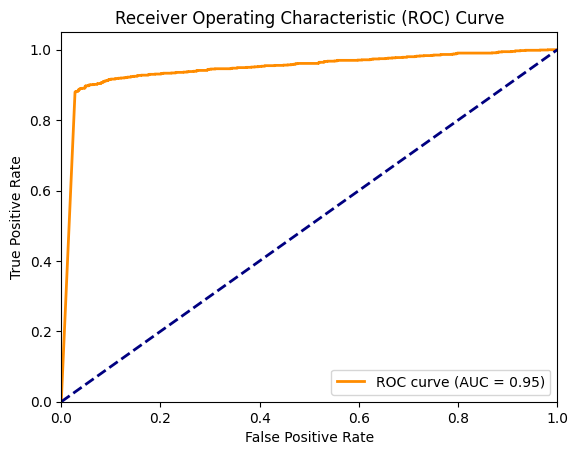

In [7]:
fpr, tpr, thresholds = roc_curve(label, outputs)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()